<a href="https://colab.research.google.com/github/dennisorellana2/Machine-Learning/blob/master/DO_Texting_Mining_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose: This script is part of group project to use Texting Mining in R.

# Team Members :B.B, D.O, J.B

# The goal is extracting useful information from an Online Job Postings dataset to conduct text mining techniques to identify patterns and/or trends in the Armenia job market from 2004-2015.

In [49]:
########################################## Install/Load Packages #########################################################

# setenv TZ for this session
Sys.setenv(TZ="America/New_York")
 install.packages("BiocManager")
BiocManager::install("Rgraphviz")

# packages used
require("NLP")
require("tm")
require("neuralnet")
require("NeuralNetTools")
require("SnowballC")
require("RColorBrewer")
require("ggplot2")
require("wordcloud")
require("biclust")
require("cluster")
require("igraph")
require("fpc")
require("stringr")
require("ggplot2")
require("reshape2")
require("graph")
require("Rgraphviz")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

Installing package(s) 'Rgraphviz'

Old packages: 'curl', 'farver', 'pillar', 'pkgbuild', 'processx', 'ps', 'rex',
  'rprojroot', 'tidyr'



In [10]:
########################################### Read the dataset  #################################################################################

# disable scientific notation and display decimals
options(scipen = 999)

# Read the data
jobs.raw <-read.csv(file="data job posts.csv", stringsAsFactors = FALSE)

# display the structure
str(jobs.raw)

# display the summary
summary(jobs.raw) 

# Number of Missing Values for Each Variable
apply(jobs.raw, 2, function (jobs.raw) sum(is.na(jobs.raw)))

'data.frame':	19001 obs. of  24 variables:
 $ jobpost         : chr  "AMERIA Investment Consulting Company\nJOB TITLE:  Chief Financial Officer\nPOSITION LOCATION: Yerevan, Armenia\"| __truncated__ "International Research & Exchanges Board (IREX)\nTITLE:   Full-time Community Connections Intern (paid internsh"| __truncated__ "Caucasus Environmental NGO Network (CENN)\nJOB TITLE:  Country Coordinator\nPOSITION DURATION:   Renewable annu"| __truncated__ "Manoff Group\nJOB TITLE:  BCC Specialist\nPOSITION LOCATION: Manila, Philippines\nJOB DESCRIPTION:  The LEAD (L"| __truncated__ ...
 $ date            : chr  "Jan 5, 2004" "Jan 7, 2004" "Jan 7, 2004" "Jan 7, 2004" ...
 $ Title           : chr  "Chief Financial Officer" "Full-time Community Connections Intern (paid internship)" "Country Coordinator" "BCC Specialist" ...
 $ Company         : chr  "AMERIA Investment Consulting Company" "International Research & Exchanges Board (IREX)" "Caucasus Environmental NGO Network (CENN)" "Manoff Grou

   jobpost              date              Title             Company         
 Length:19001       Length:19001       Length:19001       Length:19001      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
 AnnouncementCode       Term           Eligibility          Audience        
 Length:19001       Length:19001       Length:19001       Length:19001      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            

jobpost             date            Title          Company 
               0                0                7                0 
AnnouncementCode             Term      Eligibility         Audience 
           17792            11322            14071            18360 
       StartDate         Duration         Location   JobDescription 
            9325             8202               32              492 
   JobRequirment     RequiredQual           Salary     ApplicationP 
            2511              479             9353               60 
     OpeningDate         Deadline            Notes           AboutC 
             706               44            16790             6521 
          Attach             Year            Month               IT 
           17442                0                0                0

In [11]:
########################################### Data pre-processing ################################################################################
#
# copy the raw data frame to data for processing
jobs.data <- jobs.raw

# Number of Missing Values for Each Variable
apply(jobs.data, 2, function (jobs.data) sum(is.na(jobs.data)))

# Remove some columns 
jobs.data$AnnouncementCode<-NULL
jobs.data$Term<-NULL
jobs.data$Eligibility<-NULL
jobs.data$Audience<-NULL
jobs.data$StartDate<-NULL
jobs.data$Duration<-NULL
jobs.data$OpeningDate<-NULL
jobs.data$Deadline<-NULL
jobs.data$Notes<-NULL
jobs.data$Attach<-NULL

# create new columns
# create NewLocation
jobs.data$NewLocation <- str_extract(jobs.data$Location, "[a-z A-Z]+, [, a-zA-Z]+$" )

# create new NewRequiredQual from regular expressions patterns
pat1<-"Master[']*s|Bachelor[']*s|Mechanical Engineering|Engineering|Electrical Engineering|Computer Science|Finance|Economics|Accounting|Education"
pat2<-"Civil Engineering|Medical|Doctor|Business Administration|Information Technology|Information Technologies|Economics|Veterinary"
pat3<-"Physics|Mathematics|Public Health"
pattern <- paste(pat1,pat2,pat3,sep="|")
jobs.data$NewRequiredQual <- str_extract(jobs.data$RequiredQual, pattern)
jobs.data$NewRequiredQual[jobs.data$NewRequiredQual == "Bachelors"] <- "Bachelor's"
jobs.data$NewRequiredQual[jobs.data$NewRequiredQual == "Masters"] <- "Master's"

# create new variable job description length
jobs.data$JobDescriptionLength <- sapply(strsplit(jobs.data$JobDescription, " "), length)

# Create new variable Year / Month
jobs.data$YearMonth <- as.character(paste(jobs.data$Year, jobs.data$Month, sep ="/"))

# convert date format
jobs.data$jobpostdate <- as.Date(jobs.data$date,tryFormats = c("%b %d, %Y", "%b %d %H:%M"))

# correct N/A string to NA
jobs.data$JobDescription[jobs.data$JobDescription == "N/A"] <- NA

# remove NA rows
jobs.data <- jobs.data[!is.na(jobs.data$JobDescription), ]
jobs.data <- jobs.data[!is.na(jobs.data$NewLocation), ]


# change FALSE as "non-IT" and TRUE as "IT" in IT variable
jobs.data$IT[jobs.data$IT=="FALSE"] <- "non-IT"
jobs.data$IT[jobs.data$IT=="TRUE"] <- "IT"

# convert IT as factor
jobs.data$IT <- as.factor(jobs.data$IT)

# Number of Missing Values for Each Variable
apply(jobs.data, 2, function (jobs.data) sum(is.na(jobs.data)))

# display the structure
str(jobs.data)



jobpost             date            Title          Company 
               0                0                7                0 
AnnouncementCode             Term      Eligibility         Audience 
           17792            11322            14071            18360 
       StartDate         Duration         Location   JobDescription 
            9325             8202               32              492 
   JobRequirment     RequiredQual           Salary     ApplicationP 
            2511              479             9353               60 
     OpeningDate         Deadline            Notes           AboutC 
             706               44            16790             6521 
          Attach             Year            Month               IT 
           17442                0                0                0

jobpost                 date                Title 
                   0                    0                    0 
             Company             Location       JobDescription 
                   0                    0                    0 
       JobRequirment         RequiredQual               Salary 
                1918                    4                 6894 
        ApplicationP               AboutC                 Year 
                   0                 4851                    0 
               Month                   IT          NewLocation 
                   0                    0                    0 
     NewRequiredQual JobDescriptionLength            YearMonth 
                8430                    0                    0 
         jobpostdate 
                1869

'data.frame':	14977 obs. of  19 variables:
 $ jobpost             : chr  "AMERIA Investment Consulting Company\nJOB TITLE:  Chief Financial Officer\nPOSITION LOCATION: Yerevan, Armenia\"| __truncated__ "Caucasus Environmental NGO Network (CENN)\nJOB TITLE:  Country Coordinator\nPOSITION DURATION:   Renewable annu"| __truncated__ "Manoff Group\nJOB TITLE:  BCC Specialist\nPOSITION LOCATION: Manila, Philippines\nJOB DESCRIPTION:  The LEAD (L"| __truncated__ "OSI Assistance Foundation - Armenian Branch Office\nJOB TITLE:  Chief Accountant/ Finance Assistant\nPOSITION L"| __truncated__ ...
 $ date                : chr  "Jan 5, 2004" "Jan 7, 2004" "Jan 7, 2004" "Jan 11, 2004" ...
 $ Title               : chr  "Chief Financial Officer" "Country Coordinator" "BCC Specialist" "Chief Accountant/ Finance Assistant" ...
 $ Company             : chr  "AMERIA Investment Consulting Company" "Caucasus Environmental NGO Network (CENN)" "Manoff Group" "OSI Assistance Foundation - Armenian Branch Office

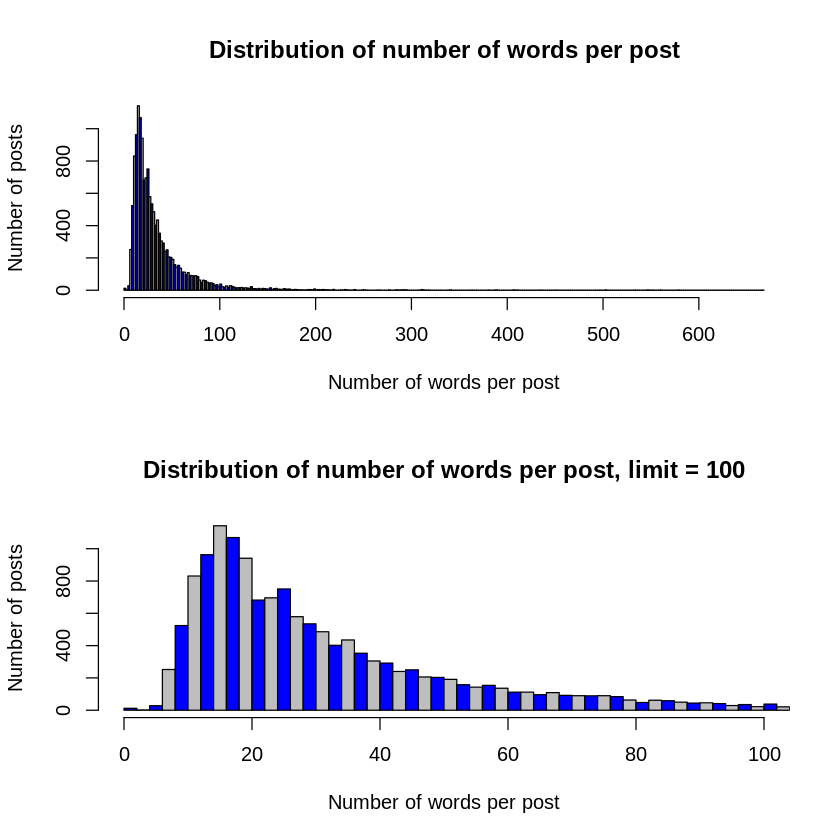

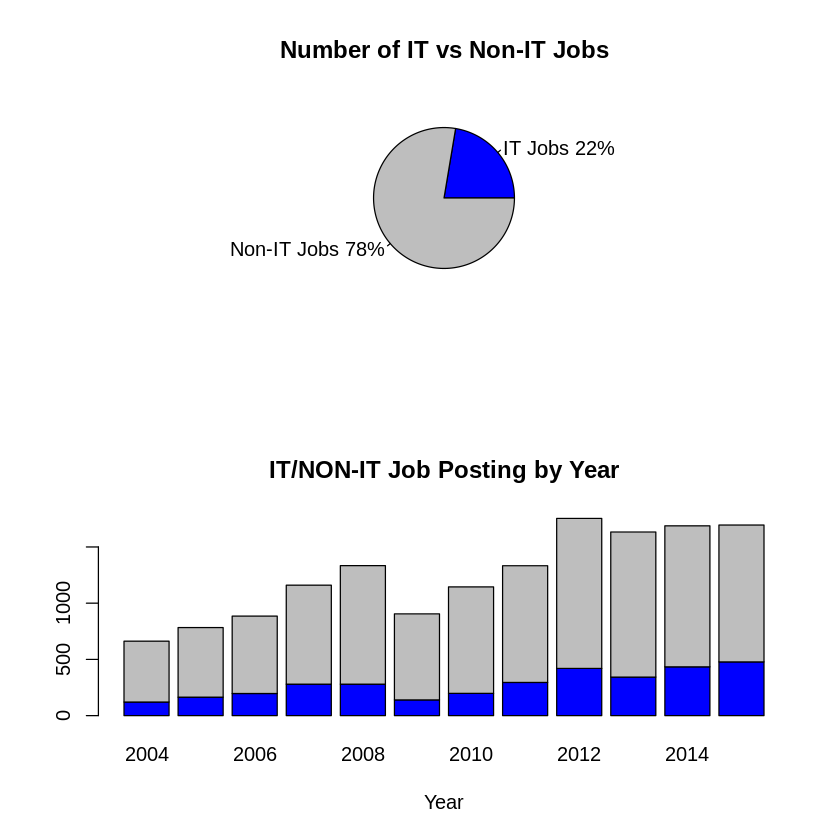

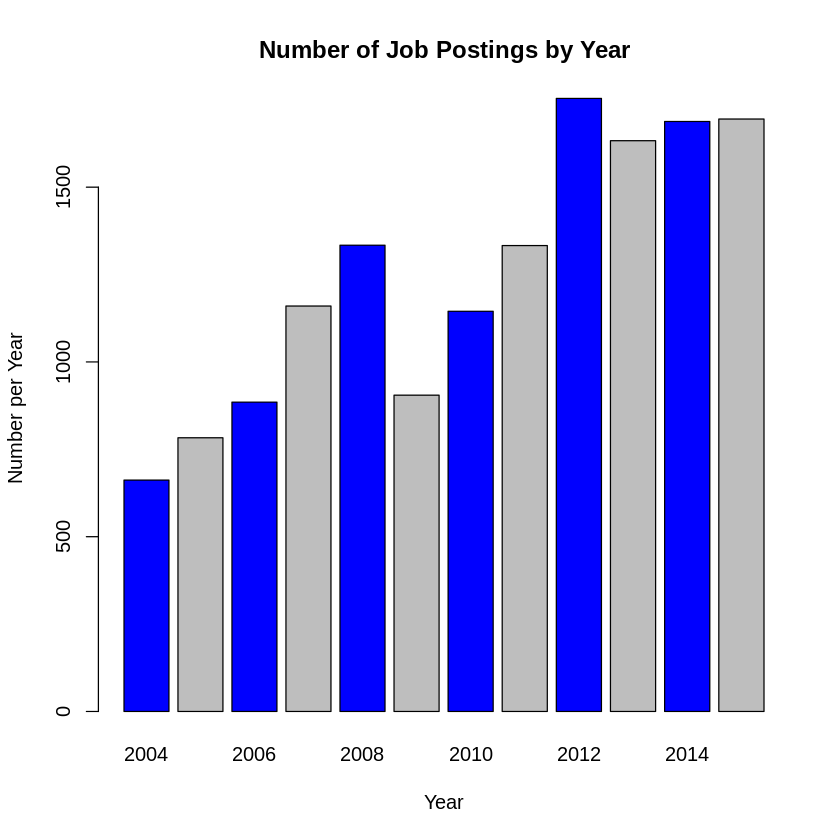

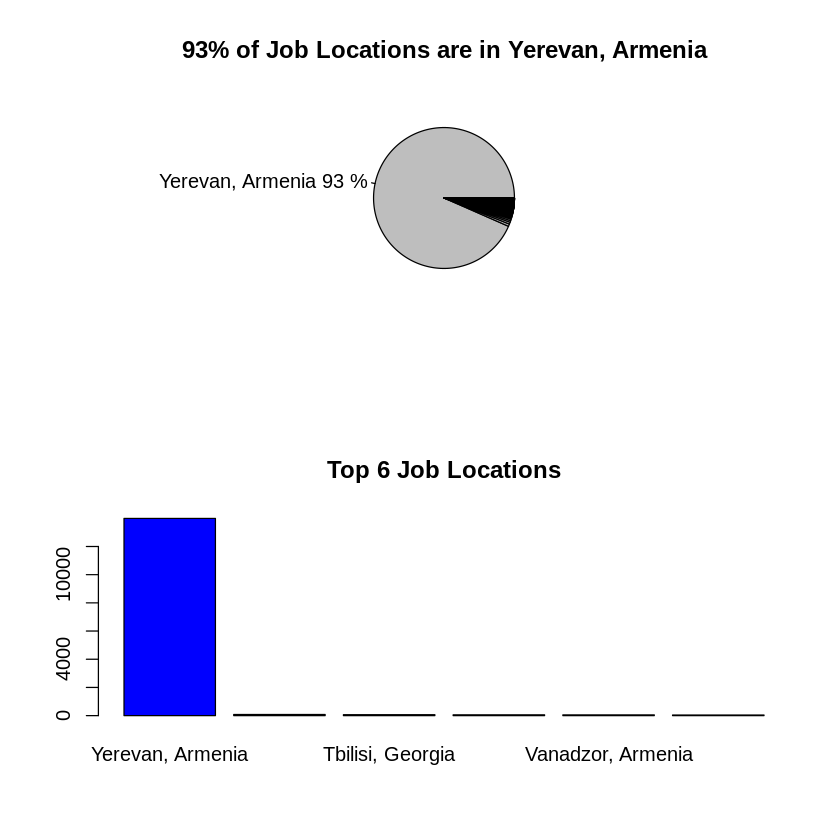

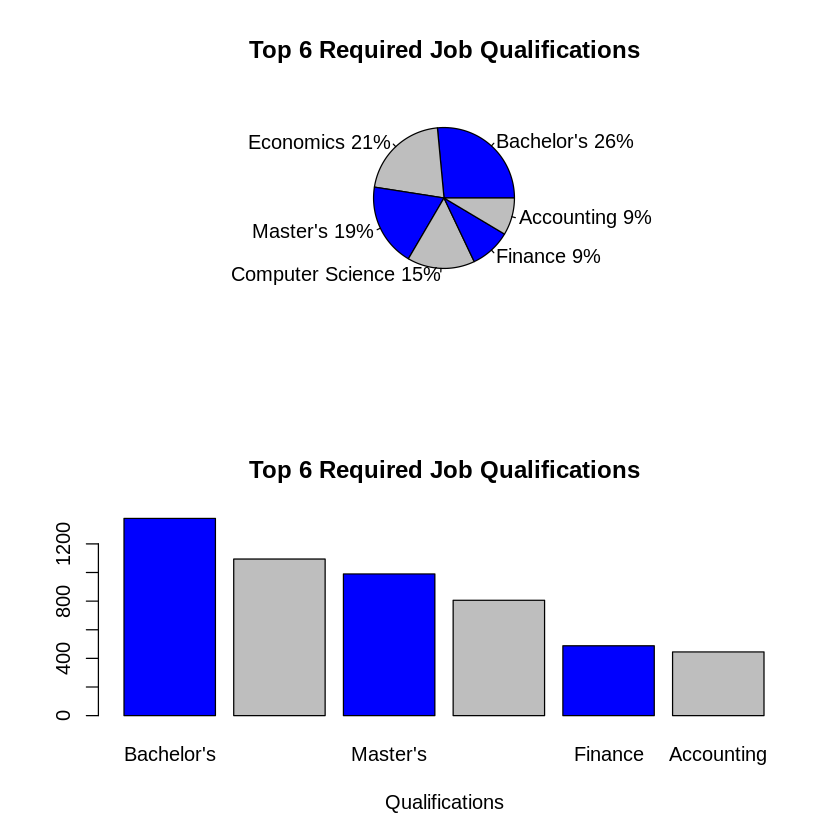

In [12]:
############################################ start exploratory analysis #################################################################################
#
# set display
par(mfrow=c(2,1)) # rows, cols
# distribution of number of words per post
hist(breaks = 250, jobs.data[ ,c("JobDescriptionLength")],
     main="Distribution of number of words per post", 
     col=c("blue", "grey"), xlab="Number of words per post", ylab="Number of posts")
hist(breaks = 250, jobs.data[ ,c("JobDescriptionLength")], 
     main="Distribution of number of words per post, limit = 100", 
     col=c("blue", "grey"), xlab="Number of words per post", ylab="Number of posts", xlim=c(0,100))

# Pie Chart with Percentages
slices <- table(jobs.data$IT)
lbls <- c("IT Jobs", "Non-IT Jobs")
pct <- round(slices/sum(slices)*100)
lbls <- paste(lbls, pct) # add percents to labels
lbls <- paste(lbls,"%",sep="") # ad % to labels
pie(slices,labels = lbls, col=c("blue", "grey"), main="Number of IT vs Non-IT Jobs")

# bar chart
barplot(table(jobs.data$IT, jobs.data$Year), col = c("blue", "gray"), xlab = "Year", main="IT/NON-IT Job Posting by Year")

par(mfrow=c(1,1)) # plot screen rows, cols

# count post per year
post_cnt<-aggregate(jobs.data$jobpost, by=list(jobs.data$Year), FUN=length)
# plot post per year
barplot(post_cnt$x,post_cnt$Group.1, xlab = "Year", ylab="Number per Year", 
        main="Number of Job Postings by Year", col=c("blue", "grey"), names.arg = post_cnt$Group.1)

par(mfrow=c(2,1)) # plot screen rows, cols

# plot top locations
loc <- aggregate(jobs.data$jobpost, by=list(jobs.data$NewLocation), FUN=length)
loc_ord2 <- loc[order(loc$x, decreasing = TRUE),]
# top locations
slices <- loc_ord2$x 
lbls <- loc_ord2$Group.1
pct <- round(slices/sum(slices)*100)
lbls <- paste(loc_ord2$Group.1, pct, "%") # add percents to labels
pie(slices,labels = c(lbls[1:1], ""), col=c("grey"), main="93% of Job Locations are in Yerevan, Armenia")
# top locations plot
barplot(loc_ord2[1:6,]$x, names.arg = loc_ord2[1:6,]$Group.1, main = "Top 6 Job Locations", col=c("blue", "grey"))

# plot top qualifications
qual <- aggregate(jobs.data$jobpost, by=list(jobs.data$NewRequiredQual), FUN=length) 
qual_ord2 <- qual[order(qual$x, decreasing = TRUE),]
# top qualifications pie
slices <- qual_ord2[1:6,]$x 
lbls <- qual_ord2[1:6,]$Group.1
pct <- round(slices/sum(slices)*100)
lbls <- paste(lbls, pct) # add percents to labels
lbls <- paste(lbls,"%",sep="") # ad % to labels
pie(slices,labels = lbls, col=c("blue", "grey"), main="Top 6 Required Job Qualifications")
# top qualifications chart
barplot(qual_ord2[1:6,]$x, names.arg = qual_ord2[1:6,]$Group.1, xlab = "Qualifications",  main="Top 6 Required Job Qualifications", col=c("blue", "grey"))

par(mfrow=c(1,1)) # rows, cols

########################################### Text Cleaning Functions ################################################
#
## Job Title
jobs_text<- jobs.data$Title 

#customize stop words
myStopwords <- c(stopwords('english'),"llc", "test", "fill", "cjsc", "responsible",
                 "new", "seeking", "position", "including", "staff", "well", "role", "provide", "team", "staff" )

# remove command for any "http" followed by any non-space letters
removeURL <- function(x) gsub("http[^[:space:]]*", "", x)

# function for removing anything other than English letters or space
removeNumPunct <- function(x) gsub("[^[:alpha:][:space:]]*", "", x)


In [13]:
########################################### Corpus Text Cleaning ################################################

# build a corpus and specify the source to be character vectors 
corpus.raw <- jobs_text %>% VectorSource() %>% Corpus()



# text cleaning for job posts                                                                          
corpus.cleaned <- corpus.raw %>%                                                         
  # convert to lower case                                                                
  tm_map(content_transformer(tolower)) %>%                                               
  # remove URLs
  tm_map(content_transformer(removeURL)) %>%
  # remove numbers and punctuations
  tm_map(content_transformer(removeNumPunct)) %>%                                        
  # remove stopwords                                                                     
  tm_map(removeWords, myStopwords) %>%                                                   
  # remove extra whitespace                                                              
  tm_map(stripWhitespace)  
 

Warning message in tm_map.SimpleCorpus(., content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., content_transformer(removeURL)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., content_transformer(removeNumPunct)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., removeWords, myStopwords):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., stripWhitespace):
“transformation drops documents”


In [14]:
##################################### Stemming and Stem Completion  ###########################################

## stem words
corpus.stemmed <- corpus.cleaned %>% tm_map(stemDocument)
## stem completion
stemCompletion2 <- function(x, dictionary) {
  x <- unlist(strsplit(as.character(x), " "))
  x <- x[x != ""]
  x <- stemCompletion(x, dictionary=dictionary)
  x <- paste(x, sep="", collapse=" ")
  stripWhitespace(x)
}

corpus.completed <- corpus.stemmed %>%
  lapply(stemCompletion2, dictionary=corpus.cleaned) %>%
 VectorSource() %>% Corpus()


Warning message in tm_map.SimpleCorpus(., stemDocument):
“transformation drops documents”


In [15]:
######################################## Before/After Text Cleaning and Stemming ##################################
# original text 
corpus.raw[[1]]$content %>% strwrap(60) %>% writeLines()

# text cleaning 
corpus.cleaned[[1]]$content %>% strwrap(60) %>% writeLines()

# stemmed text 
corpus.stemmed[[1]]$content %>% strwrap(60) %>% writeLines()

# after stem completion 
corpus.completed[[1]]$content %>% strwrap(60) %>% writeLines()

Chief Financial Officer
chief financial officer
chief financi offic
chief financial office


In [16]:
####################################### Issues in Stem Completion  ##############################################

# count word frequence 
wordFreq <- function(corpus, word) { 
  results <- lapply(corpus, 
                    function(x) grep(as.character(x), pattern=paste0("\\<",word)) ) 
  sum(unlist(results)) 
  } 

# replace old word with new word 
replaceWord <- function(corpus, oldword, newword) { 
  tm_map(corpus, content_transformer(gsub), 
         pattern=oldword, replacement=newword) }
corpus.completed_words <- corpus.completed %>% 
  replaceWord("engine", "engineer") %>% 
  replaceWord("develop", "developer") %>% 
  replaceWord("assist", "assistant") %>%  
  replaceWord("account", "accountant") %>%  
  replaceWord("programme", "program")

Warning message in tm_map.SimpleCorpus(corpus, content_transformer(gsub), pattern = oldword, :
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, content_transformer(gsub), pattern = oldword, :
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, content_transformer(gsub), pattern = oldword, :
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, content_transformer(gsub), pattern = oldword, :
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, content_transformer(gsub), pattern = oldword, :
“transformation drops documents”


In [17]:
############################################### Build Term Document Matrix ################################
## Build Term Document Matrix 
tdm <- corpus.completed_words %>% 
  TermDocumentMatrix(control = list(wordLengths = c(1, Inf))) %>% 
  print

# locate index for key terms
idx <- which(dimnames(tdm)$Terms %in% c("specialist", "developer", "management")) 
tdm[idx, 1:20] %>% as.matrix() # print 20

<<TermDocumentMatrix (terms: 2079, documents: 14977)>>
Non-/sparse entries: 42011/31095172
Sparsity           : 100%
Maximal term length: 33
Weighting          : term frequency (tf)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
specialist,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
management,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
developer,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


 [1] "office"         "specialist"     "accountant"     "assistant"     
 [5] "administration" "management"     "developer"      "software"      
 [9] "engineer"       "senior"        


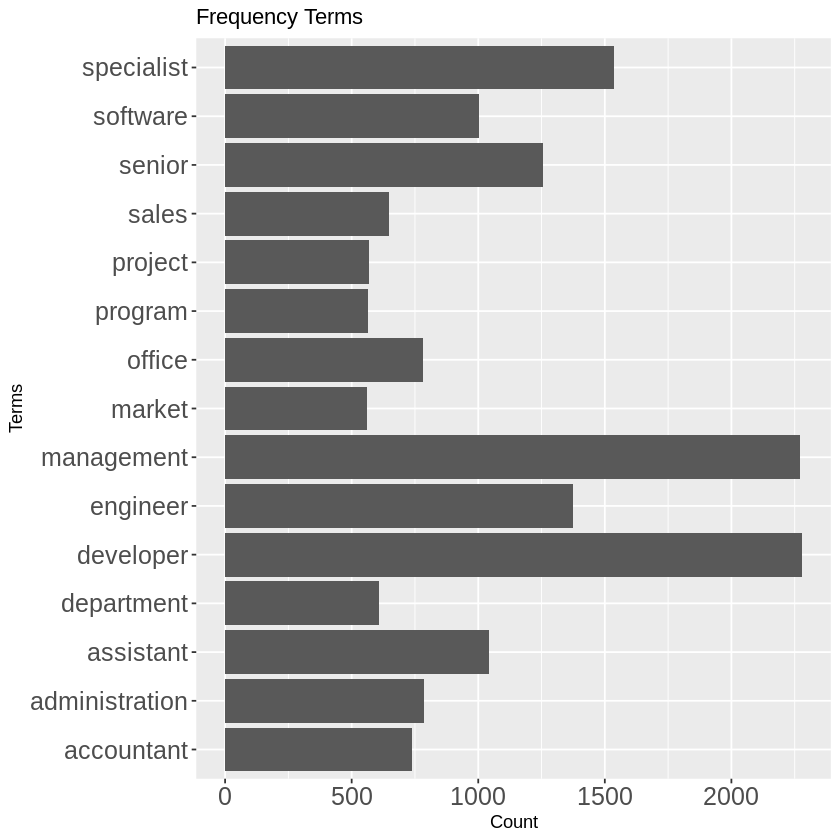

In [18]:
################################################# Top Frequent Terms ######################################
# inspect frequent words 
freq.terms <- tdm %>% findFreqTerms(lowfreq = 650) %>% print


term.freq <- tdm %>% as.matrix() %>% rowSums() 
term.freq <- term.freq %>% subset(term.freq >= 500) 
df <- data.frame(term = names(term.freq), freq = term.freq)

df<-df[order(df$freq,decreasing = TRUE),]

## plot frequent words
ggplot(df, aes(x=term, y=freq)) + geom_bar(stat="identity") + 
  xlab("Terms") + ylab("Count") + coord_flip() + 
  theme(axis.text=element_text(size=15)) + ggtitle("Frequency Terms")


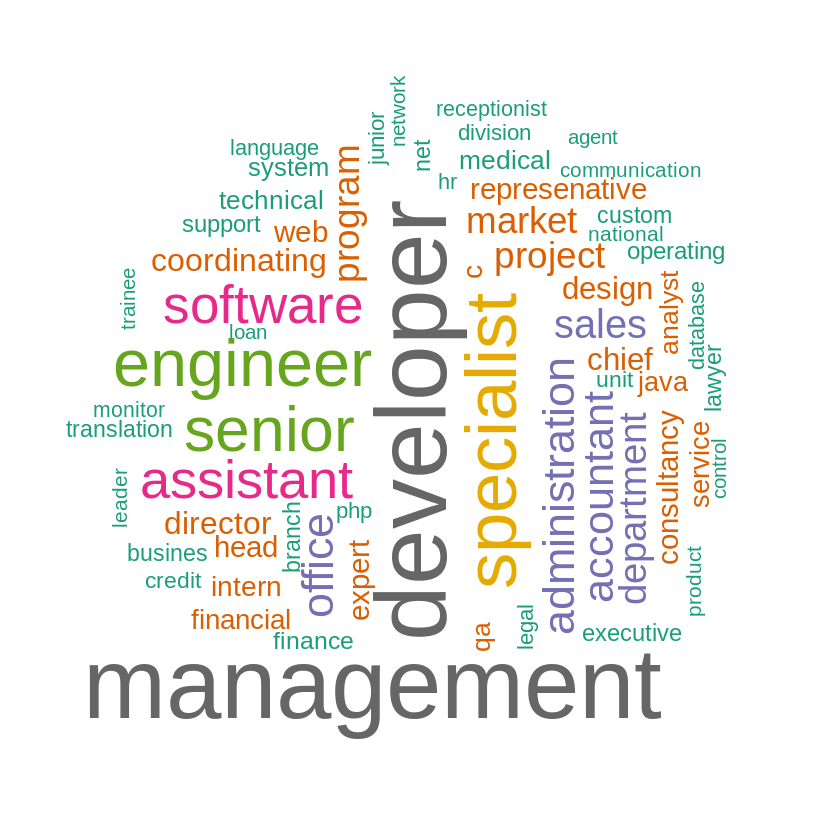

In [19]:
#################################################### Wordcloud #########################################
m <- tdm %>% as.matrix 
# calculate the frequency of words and sort it by frequency 
word.freq <- m %>% rowSums() %>% sort(decreasing = T) 
# colors 
library(RColorBrewer) 
pal <- brewer.pal(9, "BuGn")[-(1:4)]

#plot word cloud 
library(wordcloud) 
wordcloud(words = names(word.freq), freq = word.freq, min.freq = 115, rot.per=0.35, use.r.layout=FALSE,
          random.order = F, colors=brewer.pal(8, "Dark2"), scale=c(5,0.8))

In [20]:
############################################### Associations ########################################

# which words are associated with 'engineer'? 
tdm %>% findAssocs("engineer", 0.2)


# which words are associated with 'developer'? 
tdm %>% findAssocs("developer", 0.2)


# which words are associated with 'senior'? 
tdm %>% findAssocs("senior", 0.2)

$engineer
software       qa 
    0.31     0.30

$developer
    java software      net   senior      php        c 
    0.30     0.28     0.24     0.23     0.23     0.21

$senior
developer  software 
     0.23      0.22

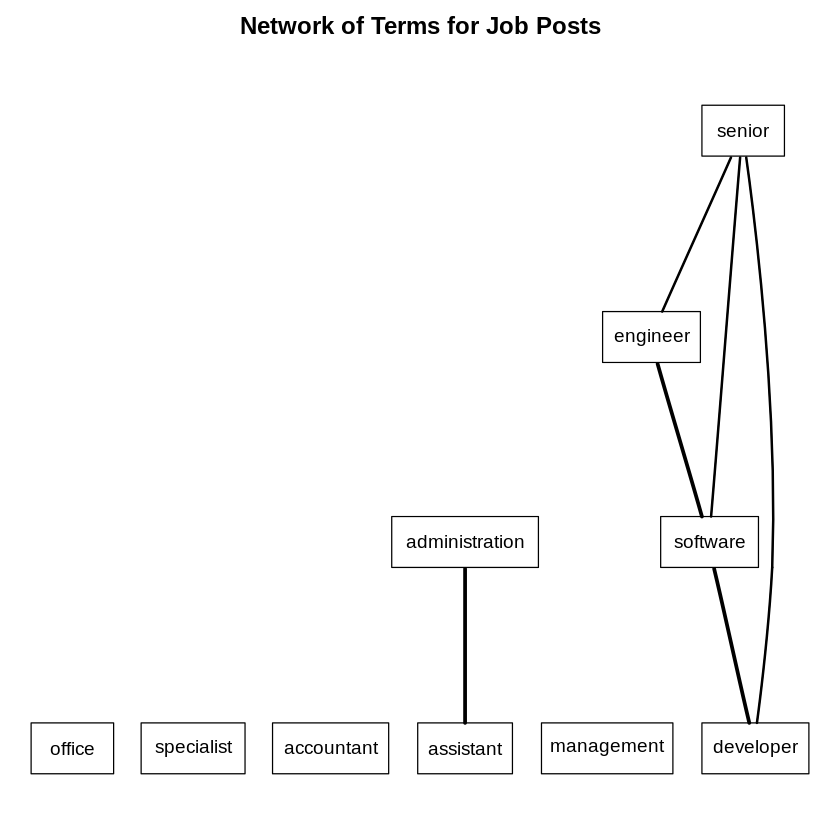

In [21]:
############################################# Network of Terms ###########################################


## network of terms 
plot(tdm, term = freq.terms, corThreshold = 0.1, weighting = T, main="Network of Terms for Job Posts") 

KMNS(*, k=2): iter=  1, indx=7


,office,specialist,accountant,assistant,administration,department,management,developer,software,engineer,sales,senior
1,0.009,0.412,0.008,0.007,0.012,0.035,0.047,0.614,0.144,0.011,0.019,0.169
2,0.066,0.001,0.063,0.090,0.066,0.043,0.186,0.000,0.042,0.118,0.051,0.056


cluster 1: developer specialist senior software management 
cluster 2: management engineer assistant office administration 


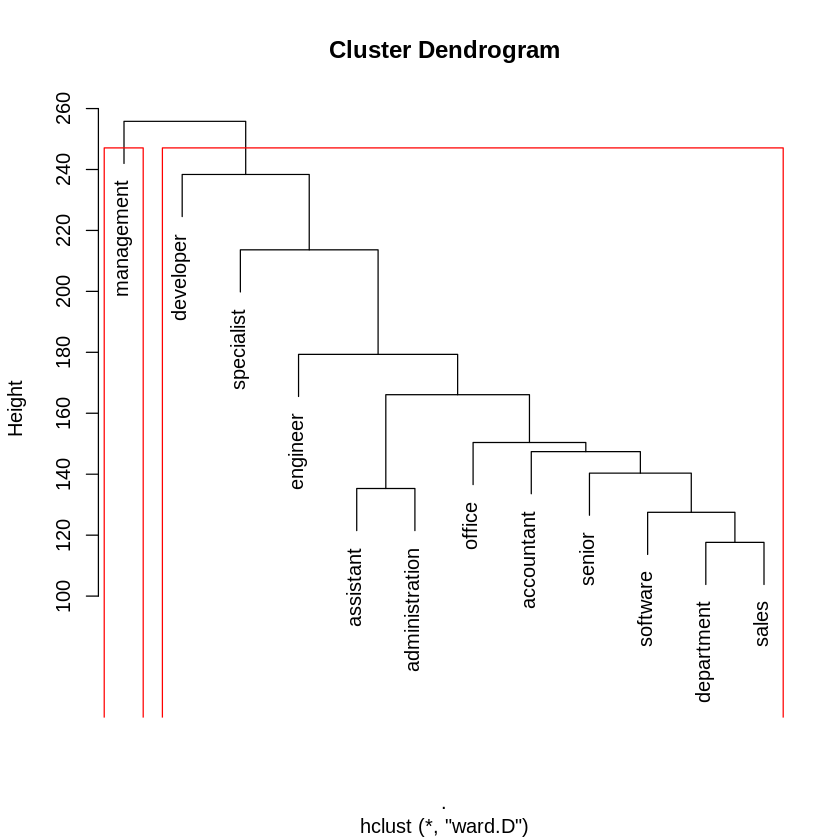

In [22]:
########################################### Hierarchical Clustering of Terms ###############################
# clustering of terms remove sparse terms
m2 <- tdm %>% removeSparseTerms(sparse = 0.96) %>% as.matrix()


# calculate distance matrix
dist.matrix <- m2 %>% scale()  %>% dist() 
# hierarchical clustering
fit <- dist.matrix %>% hclust(method = "ward.D")

# Cluster Dendrogram plot
plot(fit) 
fit %>% rect.hclust(k = 2) # cut tree into clusters
groups <- fit %>% cutree(k = 2) 


## k-means clustering of documents
m3 <- m2 %>% t() 

# transpose the matrix to cluster documents 
set.seed(1234) # set a fixed random seed to make the result reproducible 
k <- 2 # number of clusters 
kmeansResult <- kmeans(m3, k, trace = TRUE) 
round(kmeansResult$centers, digits = 3) # cluster centers   

for (i in 1:k) { 
  cat(paste("cluster ", i, ": ", sep = ""))
  s <- sort(kmeansResult$centers[i, ], decreasing = T) 
  cat(names(s)[1:5], "\n") 
  # print the jobs posts of every cluster 
  # print(jobs.data$Title[which(kmeansResult£cluster==i)]) 
}

## In conclusion, approximately 50% of all job posting require Information Technology skillsets and/or degree(s). 